In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import time
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, DataStructs
from sklearn.decomposition import PCA
from utils import *
from preprocessing import load_data
from RandomFeats import define_rand_feats
from DirectionalMLP import mlp_main

In [11]:
### CONFIG
task = 'potency'
n_comps = 32 # Num pca components
percentile = 25 # Upper pth percentile for subsets
solver = False # Solver for LogisticRegression (True - liblin, slower but better)
N = 64 # Num betas to fit (Typically 512 or 1280)
M = 500 # Num betas to generate for inference (Typically 25k-100k)

In [8]:
data = load_data(task, n_comps)

In [9]:
np.random.seed(74)
X, Y = data['train']
K = X.shape[-1]
r = K * 5
model = define_rand_feats(X, r)

In [10]:
print(X.shape)
print(Y.shape)

(44253, 32)
(44253,)


In [5]:
dirs = np.random.randn(N, K)
dirs = dirs / np.linalg.norm(dirs, axis=1, keepdims=True)

In [6]:
betas = []
accs = []
i = 0
print(f"Starting {len(dirs)} models")
start_time = time.time()
for dir in dirs:
    if i % 25 == 0 and i:
        curr_time = time.time()
        elapsed_time = (curr_time - start_time)/60 # min
        print(f"Step {i} - Time Elapsed: {elapsed_time:.2f} min - est {elapsed_time/i*len(dirs) - elapsed_time:.2f} min remaining")
        print(f"\t\tCurrent Beta Accuracy: {np.mean(np.array(accs))}")

    X_sub, X_ids = project_and_filter(X, dir, percentile)
    Y_sub = Y[X_ids]
    beta, acc = log_coeffs(model(X_sub), Y_sub, solver)

    betas.append(beta)
    accs.append(acc)
    i += 1
    if i == len(dirs) - 1: print(f"Done")

betas = np.array(betas)
accs = np.array(accs)

Starting 64 models
Step 25 - Time Elapsed: 0.36 min - est 0.56 min remaining
		Current Beta Accuracy: 0.8868717180658752
Step 50 - Time Elapsed: 0.71 min - est 0.20 min remaining
		Current Beta Accuracy: 0.8880183497606394
Done


In [7]:
betas = tf.squeeze(betas)
dirs = tf.constant(dirs)
print("Modeling Training complete with Subset Accuracies: ", np.mean(accs))

Modeling Training complete with Subset Accuracies:  0.887992887982793


Accuracy:  0.5955082742316785
Precision:  0.6278359511343804
Recall:  0.6264693077927732


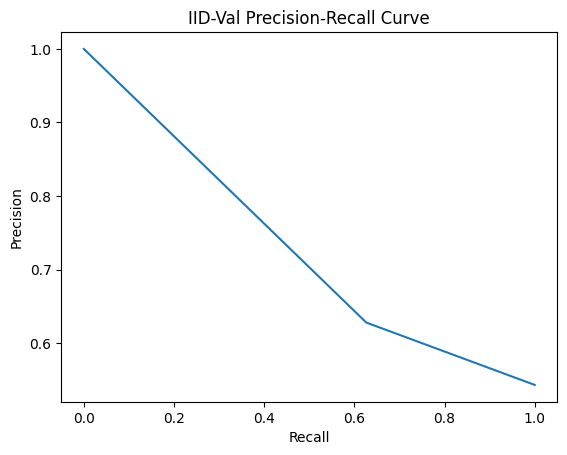

In [8]:
# Eval on iid val data
X_iid_val, Y_iid_val = data['iid_val']
X_iid_val_rand = model(X_iid_val)
evaluate(X_iid_val_rand, Y_iid_val, betas)

In [9]:
# Beta Model
mlp_ret = mlp_main(np.array(dirs), np.array(betas), X, model(X), percentile)
print(f"MLP Metrics:\n\tTest Loss - {mlp_ret['test_loss']}\n\Agreement: Overall - {mlp_ret['overall_agreement']}, Subset - {mlp_ret['subset_agreement']}")

Epoch 1/10


c:\ProgramData\anaconda3\envs\EveryDirHoldsSoln\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1402 
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1364
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1333 
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1304
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1266
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1232
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1202
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1160
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1124
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1090
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1242
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
MLP Metrics:
	Test Loss - 0.12418270111083984
\Agreement: Overall - 0.5922513583746751, Subset - 0.6236697959585633


In [10]:
# Draw new betas
M = 25_000
gen_dirs = np.random.randn(M, K)
gen_dirs = gen_dirs / np.linalg.norm(gen_dirs, axis=1, keepdims=True)
gen_betas = mlp_ret['mlp'].predict(gen_dirs)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy:  0.5375361656768692
Precision:  0.4784201954397394
Recall:  0.40088706925963835


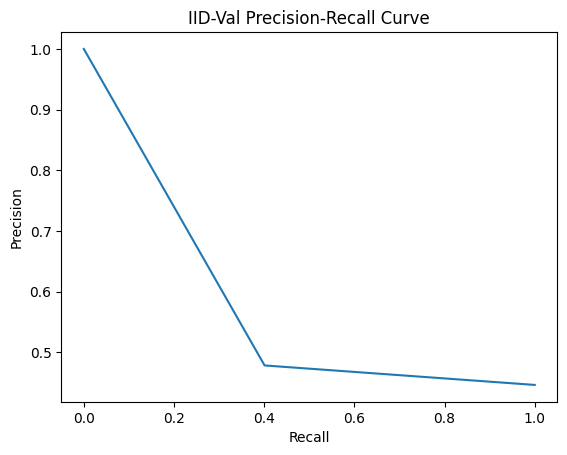

In [12]:
# Eval on ood val data
X_ood_val, Y_ood_val = data['ood_val']
X_ood_val_rand = model(X_ood_val)
evaluate(X_ood_val_rand, Y_ood_val, gen_betas)

Accuracy:  0.481369150779896
Precision:  0.6197936568589989
Recall:  0.3845424371740161


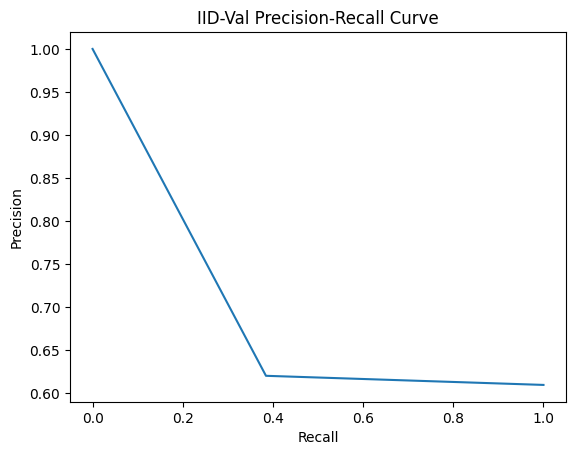

In [13]:
# Eval on ood test data
X_ood_test, Y_ood_test = data['ood_test']
X_ood_test_rand = model(X_ood_test)
evaluate(X_ood_test_rand, Y_ood_test, gen_betas)